# Введение в искусственные нейронные сети
# Урок 6. Сегментация

## Практическое задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результат. Что помогло повысить точность?
 
3. *Попробуйте свои силы в задаче City Scapes на Kaggle - https://www.kaggle.com/dansbecker/cityscapes-image-pairs. 

In [ ]:
import tensorflow.compat.v2 as tf
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output

import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

# tf.config.experimental.set_visible_devices([], 'GPU')

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/gdrive')

In [ ]:
path_images_train = '/gdrive/My Drive/GeekBrains_neural_networks/archive/cityscapes_data/train/'
path_images_val = '/gdrive/My Drive/GeekBrains_neural_networks/archive/cityscapes_data/val/'

In [ ]:
img_train = os.listdir(path_images_train)
img_val = os.listdir(path_images_val)

(256, 512, 3)


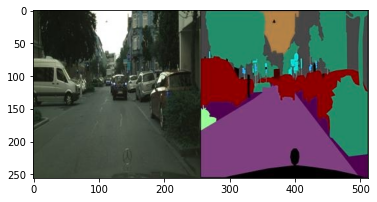

In [ ]:
img_example = cv2.imread(path_images_train + img_train[0])
plt.imshow(img_example)
print(img_example.shape)

In [ ]:
size_y = img_example.shape[0]
size_x = img_example.shape[1]
norm_size_x_for_image = int(size_x / 2)
len_train = 2000

In [ ]:
%%time
x_train = np.zeros((len_train, size_y, norm_size_x_for_image, 3))
y_train = np.zeros((len_train, size_y, norm_size_x_for_image, 3))
index = 0

for name_img in img_train[:len_train]:
    img = cv2.imread(path_images_train+name_img)[:,:256]/256
    mask = cv2.imread(path_images_train+name_img)[:,256:]/256
    x_train[index] = tf.image.resize(img, (256, 256))
    y_train[index] = tf.image.resize(mask, (256, 256))
    index = index + 1

CPU times: user 13.9 s, sys: 4.9 s, total: 18.8 s
Wall time: 33.5 s


In [ ]:
OUTPUT_CHANNELS = 3
EPOCHS = 50 
BATCH = 16

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256,256,3),
                                               include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128x128
    'block_3_expand_relu',   # 64x64
    'block_6_expand_relu',   # 32x32
    'block_13_expand_relu',  # 16x16
    'block_16_project',      # 8x8
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),  # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=(256,256,3))
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #128x128 -> 256x256

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
x_test = x_train[1500:]
y_test = y_train[1500:]
x_train = x_train[:1500]
y_train = y_train[:1500]

In [ ]:
model_history = model.fit(x_train, y_train, 
                          epochs=EPOCHS,
                          batch_size=BATCH,
                          validation_data=(x_test, y_test))

Epoch 1/50
94/94 [==============================] - 222s 2s/step - loss: 1.3161 - accuracy: 0.3366 - val_loss: 1.1524 - val_accuracy: 0.3353
Epoch 2/50
94/94 [==============================] - 221s 2s/step - loss: 1.1548 - accuracy: 0.3430 - val_loss: 1.1490 - val_accuracy: 0.3390
Epoch 3/50
94/94 [==============================] - 222s 2s/step - loss: 1.1519 - accuracy: 0.3500 - val_loss: 1.1462 - val_accuracy: 0.3544
Epoch 4/50
94/94 [==============================] - 222s 2s/step - loss: 1.1485 - accuracy: 0.3552 - val_loss: 1.1421 - val_accuracy: 0.3478
Epoch 5/50
94/94 [==============================] - 233s 2s/step - loss: 1.1388 - accuracy: 0.3574 - val_loss: 1.1316 - val_accuracy: 0.3402
Epoch 6/50
94/94 [==============================] - 222s 2s/step - loss: 1.1262 - accuracy: 0.3676 - val_loss: 1.1956 - val_accuracy: 0.3451
Epoch 7/50
94/94 [==============================] - 221s 2s/step - loss: 1.1195 - accuracy: 0.3792 - val_loss: 1.1109 - val_accuracy: 0.3682
Epoch 8/50
94

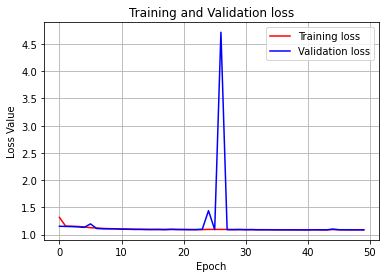

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.grid('on')
plt.legend()
plt.show()

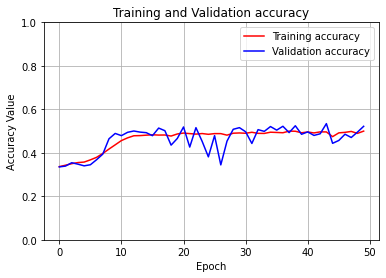

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.grid('on')
plt.legend()
plt.show()

1. Данные и обучение модели занимают достаточно много ОЗУ, поэтому для обучения было использовано 1500 объектов из 2975. Для валидации было использовано 500 объектов. 
2. Для стабильного результата достаточно около 35 эпох обучения. 
3. Наилучший полученный результат метрики accuracy на валидации составляет 53.43